In [1]:
import os
import pandas as pd
%matplotlib inline
from path import Path
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [2]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mferb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [3]:
# Read your api key environment variable
api_key = os.getenv("NEWS_API_KEY")

In [4]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [5]:
# Fetch the Bitcoin news articles
def news_api_call(search_term,language="en",page_size=100,sort_by="relevancy",sources=None,domains=None,**kwargs):
    
    """Makes call to Googles newsapi.org service.
        -Required Parameter: search_term in form of string.  Can include multiple words: "term1 and term2"  
        -Optional Parameters: language(default="en"), page_size(default=100),sort_by(default="relevancy"),sources(default=None),domains(default=None)"""
    
    # Read your api key environment variable
    api_key = os.getenv("NEWS_API_KEY")

    # Create a newsapi client
    newsapi = NewsApiClient(api_key=api_key)

    articles = newsapi.get_everything(
        q=search_term,
        sources=sources,
        domains=domains,
        language=language,
        page_size=page_size,
        sort_by=sort_by,
    )
    
    
    return articles
    

In [6]:
# Complete the tokenizer function
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english'))  
#adding custom stopwords to our stopwords set
custom_sw =['char','chars','say','fucking']
sw.update(custom_sw)
regex = re.compile(r"[^a-zA-Z ]")

def clean_tokens(text):
    """Cleans and tokenizes text using nltk stopwords, regex to remove symols, lemmatizer."""
    #Apply regex filter 
    regex_filter = regex.sub('', text)
    #Get Tokens
    tokens = word_tokenize(regex_filter)
    #Set to lowercase if not in Stop Words list
    lowered_sw = [word.lower() for word in tokens if word.lower() not in sw]
    #get lemmatized clean tokens
    clean_tokens = [lemmatizer.lemmatize(word) for word in lowered_sw]
    return clean_tokens


In [7]:
#check to see if custom_sw were added to list of sw
print(len(sw))

183


In [8]:
#sentiment function using NLTK Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
        

In [9]:
def news_api_df(articles_response,search_term,tokenize=False,sentiment=False,**kwargs):
    
    
    articles_list = []
    
    for article in articles_response['articles']:
        try:
            articles_list.append({
                "date":article['publishedAt'][:10],
                "source":article['source']['name'],
                "url":article['url'],
                "author":article['author'],
                "text":article['content'],
                "search_term":search_term
            })

        except AttributeError:
            pass
    
    articles_df = pd.DataFrame(articles_list)
    
    columns = ['date','search_term','source','url','author','text']
    
    articles_df = articles_df[columns]
    
    articles_df['text'] = articles_df['text'].astype(str)
    
    if tokenize:
    
        articles_df['clean_tokens'] = articles_df['text'].apply(clean_tokens)
        
        if sentiment:
            
            sentiment_score_list = []
            
            for article in articles_df['clean_tokens']:
                string = " ".join(article)
                sentiment_score = analyzer.polarity_scores(string)
                sentiment_score_list.append(sentiment_score)

            sentiment_df = pd.DataFrame(sentiment_score_list)
            
            sentiment_df.columns = ['compound','negative','neutral','positive']
            
            articles_df = pd.concat([articles_df, sentiment_df], axis=1)
            
            return articles_df
        
        else:
            
            return articles_df

    if sentiment:

        sentiment_score_list = []

        for article in articles_df['text']:
            sentiment_score = analyzer.polarity_scores(article)
            sentiment_score_list.append(sentiment_score)

        sentiment_df = pd.DataFrame(sentiment_score_list)

        sentiment_df.columns = ['compound','negative','neutral','positive']

        articles_df = pd.concat([articles_df, sentiment_df], axis=1)

        return articles_df
    
    else:
        
        return articles_df
    

    

   

In [10]:
def news_articles_df(search_term,**kwargs):
    return news_api_df(news_api_call(search_term,**kwargs),search_term,**kwargs)

In [11]:
bitcoin_sentiment_df = news_articles_df('bitcoin',page_size=100,tokenize=True,sentiment=True)

In [12]:
bitcoin_sentiment_df.head(10)

,date,search_term,source,url,author,text,clean_tokens,compound,negative,neutral,positive
0,2019-10-19,bitcoin,Engadget,https://www.engadget.com/2019/10/19/htcs-exodu...,Igor Bonifacic,At least that's the idea. While it's not as in...,"[least, thats, idea, intensive, mining, bitcoi...",0.2263,0.000,0.927,0.073
1,2019-10-07,bitcoin,Gizmodo.com,https://gizmodo.com/whats-going-to-happen-with...,Daniel Kolitz,"Since its inception in 2009, Bitcoin has made ...","[since, inception, bitcoin, made, ruined, fort...",-0.6249,0.221,0.702,0.077
2,2019-10-02,bitcoin,The Verge,https://www.theverge.com/2019/10/2/20895270/ja...,Russell Brandom,New allegations against a bitcoin developer sp...,"[new, allegation, bitcoin, developer, spurred,...",-0.7845,0.231,0.769,0.000
3,2019-10-16,bitcoin,Mashable,https://mashable.com/article/dark-web-child-po...,Jack Morse,Say it with me: Bitcoin is not anonymous. \r\n...,"[bitcoin, anonymousthree, hundred, thirtyseven...",-0.4767,0.124,0.876,0.000
4,2019-10-16,bitcoin,Gizmodo.com,https://gizmodo.com/huge-child-porn-ring-buste...,Matt Novak,Federal authorities in the U.S. have unsealed ...,"[federal, authority, u, unsealed, charge, sout...",0.3612,0.058,0.804,0.138
5,2019-10-20,bitcoin,Mashable,https://mashable.com/shopping/oct-20-blockchai...,Miller Kern,TL;DR: The in-depth Complete Blockchain and Et...,"[tldr, indepth, complete, blockchain, ethereum...",0.5719,0.000,0.802,0.198
6,2019-10-12,bitcoin,The Next Web,https://thenextweb.com/hardfork/2019/10/12/sat...,Satoshi Nakaboto,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ...",0.0000,0.000,1.000,0.000
7,2019-10-27,bitcoin,The Next Web,https://thenextweb.com/hardfork/2019/10/27/sat...,Satoshi Nakaboto,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ...",0.0000,0.000,1.000,0.000
8,2019-10-15,bitcoin,The Next Web,https://thenextweb.com/hardfork/2019/10/15/sat...,Satoshi Nakaboto,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ...",0.0000,0.000,1.000,0.000
9,2019-10-22,bitcoin,The Next Web,https://thenextweb.com/hardfork/2019/10/22/sat...,Satoshi Nakaboto,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ...",0.0000,0.000,1.000,0.000


In [13]:
eth_sentiment_df = news_articles_df('ethereum',page_size=100,tokenize=True,sentiment=True)

In [14]:
eth_sentiment_df.head(10)

,date,search_term,source,url,author,text,clean_tokens,compound,negative,neutral,positive
0,2019-10-20,ethereum,Mashable,https://mashable.com/shopping/oct-20-blockchai...,Miller Kern,TL;DR: The in-depth Complete Blockchain and Et...,"[tldr, indepth, complete, blockchain, ethereum...",0.5719,0.000,0.802,0.198
1,2019-10-02,ethereum,The Next Web,https://thenextweb.com/hardfork/2019/10/02/ike...,David Canellis,IKEA Iceland has used Ethereum ETHtechnology t...,"[ikea, iceland, used, ethereum, ethtechnology,...",0.3818,0.000,0.894,0.106
2,2019-10-24,ethereum,TechCrunch,http://techcrunch.com/2019/10/24/announcing-th...,Jordan Crook,Disrupt Berlin is right around the corner. And...,"[disrupt, berlin, right, around, corner, plent...",0.6124,0.000,0.815,0.185
3,2019-10-19,ethereum,Engadget,https://www.engadget.com/2019/10/19/htcs-exodu...,Igor Bonifacic,At least that's the idea. While it's not as in...,"[least, thats, idea, intensive, mining, bitcoi...",0.2263,0.000,0.927,0.073
4,2019-10-23,ethereum,The Next Web,https://thenextweb.com/hardfork/2019/10/23/eth...,Matthew Beedham,"he plaBy now, you should almost certainly know...","[plaby, almost, certainly, know, ethereum, eth...",0.4601,0.000,0.846,0.154
5,2019-10-17,ethereum,The Next Web,https://thenextweb.com/offers/2019/10/17/block...,TNW Deals,TLDR: The Complete Blockchain and Ethereum Pro...,"[tldr, complete, blockchain, ethereum, program...",0.4019,0.000,0.886,0.114
6,2019-10-09,ethereum,The Next Web,https://thenextweb.com/hardfork/2019/10/09/eth...,Matthew Beedham,"Further to its previous blockchain exploits, t...","[previous, blockchain, exploit, united, nation...",0.3400,0.063,0.811,0.126
7,2019-10-10,ethereum,The Next Web,https://thenextweb.com/hardfork/2019/10/10/per...,David Canellis,"Australias Perth Mint, one of the worlds large...","[australia, perth, mint, one, world, largest, ...",0.2500,0.047,0.872,0.081
8,2019-10-13,ethereum,Slashdot.org,https://news.slashdot.org/story/19/10/12/23122...,EditorDavid,Announced at Ethereum Foundation's Devcon 5 co...,"[announced, ethereum, foundation, devcon, conf...",0.0000,0.000,1.000,0.000
9,2019-10-07,ethereum,The Next Web,https://thenextweb.com/hardfork/2019/10/07/blo...,David Canellis,The total transactional volume of blockchain a...,"[total, transactional, volume, blockchain, app...",-0.4588,0.130,0.815,0.056


In [15]:
# Describe the Bitcoin Sentiment
bitcoin_sentiment_df.describe()

,compound,negative,neutral,positive
count,100.000000,100.000000,100.000000,100.00000
mean,-0.027072,0.083600,0.833030,0.08333
std,0.452235,0.092149,0.137551,0.10271
min,-0.906200,0.000000,0.523000,0.00000
25%,-0.386825,0.000000,0.732250,0.00000
50%,0.000000,0.070000,0.830000,0.05700
75%,0.345300,0.148000,1.000000,0.12525
max,0.934900,0.413000,1.000000,0.46200


In [16]:
# Describe the Ethereum Sentiment
eth_sentiment_df.describe()

,compound,negative,neutral,positive
count,100.000000,100.000000,100.000000,100.000000
mean,0.162823,0.045830,0.858760,0.095380
std,0.407855,0.073679,0.112731,0.094411
min,-0.836000,0.000000,0.560000,0.000000
25%,0.000000,0.000000,0.796000,0.000000
50%,0.226300,0.000000,0.876000,0.087500
75%,0.421500,0.077000,0.924750,0.154500
max,0.900100,0.352000,1.000000,0.406000


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum

Q: Which coin had the highest compound score?

A: Bitcoin

Q. Which coin had the highest positive score?

A: Bitcoin

In [17]:
#extracting list of urls which could be fed to scraper for further data fetching
eth_sentiment_df['url'].to_list()

['https://mashable.com/shopping/oct-20-blockchain-and-ethereum-programmer-online-courses/',
 'https://thenextweb.com/hardfork/2019/10/02/ikea-iceland-smart-contracts-ethereum-tradeshift-monerium-invoice-nordic-store/',
 'http://techcrunch.com/2019/10/24/announcing-the-disrupt-berlin-2019-agenda/',
 'https://www.engadget.com/2019/10/19/htcs-exodus-1s-can-run-a-full-bitcoin-node-for-under-250/',
 'https://thenextweb.com/hardfork/2019/10/23/ethereum-q2-performance-etoro-coin-cryptocurrency/',
 'https://thenextweb.com/offers/2019/10/17/blockchaining-is-the-future-of-data-tech-so-learn-it-all-for-just-29/',
 'https://thenextweb.com/hardfork/2019/10/09/ethereum-foundation-first-donation-unicef-cryptocurrency/',
 'https://thenextweb.com/hardfork/2019/10/10/perth-mint-australia-government-blockchain-ethereum-gold-backed-cryptocurrency/',
 'https://news.slashdot.org/story/19/10/12/2312213/new-openlibra-cryptocurrency-like-libra-but-not-run-by-facebook',
 'https://thenextweb.com/hardfork/2019/10

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [18]:
## See above.  Used a nested function for this section  When I call news_articles_df if tokenize=True is passed as argument, the tokens are created in a column in the dataFrame

---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [19]:
from collections import Counter
from nltk import ngrams

In [20]:
# Generate the Bitcoin N-grams where N=2
#generic function for turning many lists into one (concatenating lists)
list_of_lists_btc = bitcoin_sentiment_df['clean_tokens']

def one_list(list_of_lists):
    unified_list = [item for list_ in list_of_lists for item in list_]
    #[item for sublist in list for item in sublist]
    
    return unified_list

In [21]:
list_of_btc_tokens = one_list(list_of_lists_btc)

In [22]:
print (len(list_of_btc_tokens))

2469


In [23]:
#Use the nltk ngrams function to create our bigrams
btc_bigrams = ngrams((list_of_btc_tokens), n = 2)

In [24]:
#Count bigrams using Counter function
btc_bigrams_count = Counter(btc_bigrams)

In [25]:
#Get 10 most common bigrams
btc_bigrams_count.most_common(10)

[(('satoshi', 'nakaboto'), 44),
 (('bitcoin', 'btc'), 29),
 (('robot', 'colleague'), 22),
 (('colleague', 'satoshi'), 22),
 (('nakaboto', 'writes'), 22),
 (('writes', 'bitcoin'), 22),
 (('every', 'daywelcome'), 22),
 (('daywelcome', 'another'), 22),
 (('another', 'edition'), 22),
 (('edition', 'bitcoin'), 22)]

In [26]:
# Generate the Ethereum N-grams where N=2
#generic function for turning many lists into one (concatenating lists)
list_of_lists = eth_sentiment_df['clean_tokens']

def one_list(list_of_lists):
    unified_list = [item for list_ in list_of_lists for item in list_]
    #[item for sublist in l for item in sublist]
    
    return unified_list

In [27]:
#Call our one_list function to make a big list from our many lists of tokens
list_of_eth_tokens = one_list(list_of_lists)

In [28]:
#Use the nltk ngrams function to create our bigrams
eth_bigrams = ngrams((list_of_eth_tokens), n = 2)

In [29]:
#Count bigrams using Counter function
eth_bigrams_count = Counter(eth_bigrams)

In [30]:
#Get 10 most common bigrams
eth_bigrams_count.most_common(10)

[(('early', 'morning'), 14),
 (('ethereum', 'ended'), 13),
 (('ended', 'day'), 12),
 (('morning', 'intraday'), 11),
 (('saw', 'ethereum'), 10),
 (('start', 'day'), 9),
 (('day', 'saw'), 9),
 (('intraday', 'high'), 7),
 (('intraday', 'low'), 6),
 (('smart', 'contract'), 5)]

In [31]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [32]:
# Get the top 10 words for Bitcoin
token_count(list_of_btc_tokens)

[('bitcoin', 110),
 ('satoshi', 48),
 ('nakaboto', 44),
 ('btc', 29),
 ('today', 27),
 ('cryptocurrency', 25),
 ('every', 24),
 ('past', 24),
 ('used', 24),
 ('writes', 23)]

In [33]:
# Get the top 10 words for Ethereum
token_count(list_of_eth_tokens)

[('ethereum', 85),
 ('bitcoin', 30),
 ('blockchain', 29),
 ('day', 26),
 ('morning', 18),
 ('early', 16),
 ('cryptocurrency', 14),
 ('ethereumethereum', 13),
 ('ended', 13),
 ('intraday', 13)]

# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

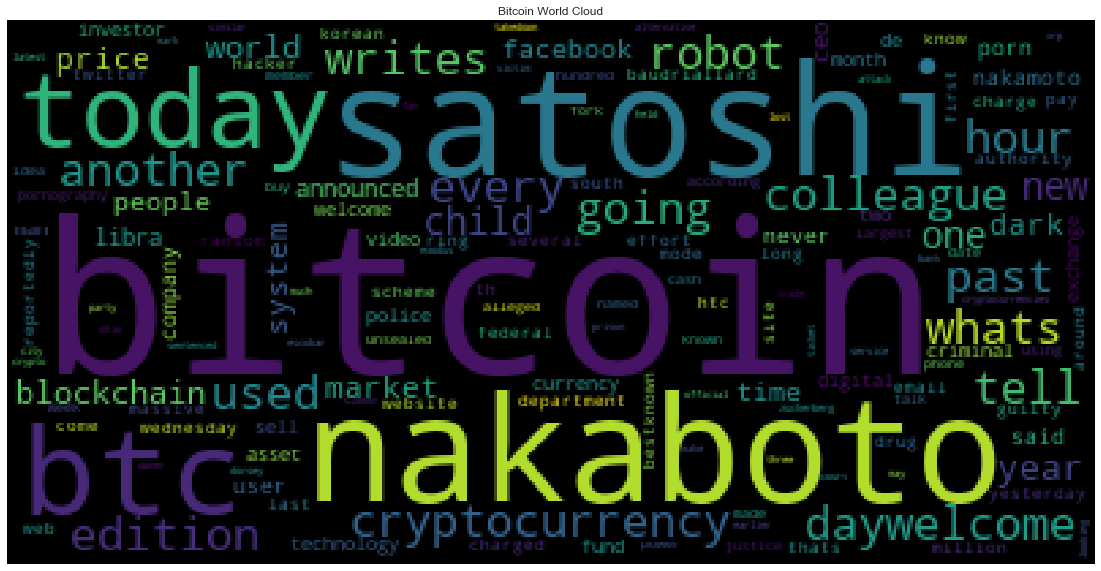

In [35]:
# Generate the Bitcoin word cloud
str_of_btc_tokens = ' '.join(list_of_btc_tokens)
wordcloud = WordCloud(collocations = False).generate(str_of_btc_tokens)
plt.axis("off")
plt.title('Bitcoin World Cloud')
plt.imshow(wordcloud)

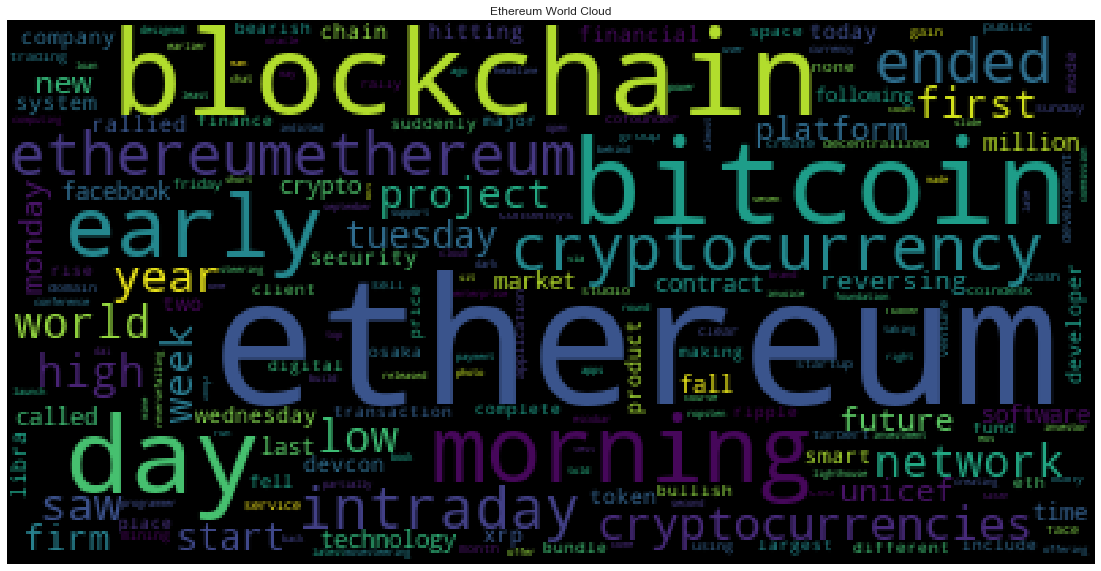

In [36]:
# Generate the Ethereum word cloud
str_of_etc_tokens = ' '.join(list_of_eth_tokens)
wordcloud = WordCloud(collocations = False).generate(str_of_etc_tokens)
plt.axis('off')
plt.title('Ethereum World Cloud')
plt.imshow(wordcloud)

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [37]:
import spacy
from spacy import displacy

In [38]:
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm

In [39]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [42]:
# Concatenate all of the bitcoin text together
all_btc_text = ' '.join(bitcoin_sentiment_df['text'])


In [43]:
# Run the NER processor on all of the text
bitcoin_ner = nlp(all_btc_text)
# Add a title to the document
bitcoin_ner.user_data['title'] = "Bitcoin NER"

In [44]:
# Render the visualization
displacy.render(bitcoin_ner, style = 'ent')

In [52]:
# List all Entities
list_of_ent_btc = [(ent.text, ent.label_) for ent in bitcoin_ner.ents]
print(list_of_ent_btc)

[('Bitcoin', 'PERSON'), ('HTC', 'ORG'), ('2009', 'DATE'), ('Bitcoin', 'PERSON'), ('millions', 'CARDINAL'), ('+10529', 'NORP'), ('Jacob Appelbaum', 'PERSON'), ('Ingo Wagner / Getty Images', 'ORG'), ('the summer of 2016', 'DATE'), ('Tor', 'ORG'), ('Jacob Appelbaum', 'PERSON'), ('Bitcoin', 'PERSON'), ('Three hundred and thirty-seven', 'CARDINAL'), ('last year', 'DATE'), ('U.S.', 'GPE'), ('South Korean', 'NORP'), ('Welcome', 'FAC'), ('Video', 'NORP'), ('Bitcoin', 'PERSON'), ('Complete Blockchain and Ethereum Programmer', 'ORG'), ('just $24', 'MONEY'), ('Bitcoin', 'PERSON'), ('Satoshi Nakaboto', 'PERSON'), ('Bitcoin BTC', 'PERSON'), ('Bitcoin', 'PERSON'), ('Today', 'DATE'), ('Satoshi Nakaboto', 'PERSON'), ('Bitcoin', 'PERSON'), ('the past 24 hours', 'TIME'), ('Rousseau', 'PERSON'), ('Satoshi Nakaboto', 'PERSON'), ('Bitcoin', 'PERSON'), ('Bitcoin', 'PERSON'), ('Today', 'DATE'), ('Satoshi Nakaboto', 'PERSON'), ('Bitcoin', 'PERSON'), ('the past 24 hours', 'TIME'), ('Baudriallard', 'PERSON'), (

---

## Ethereum NER

In [54]:
# Concatenate all of the bitcoin text together
all_eth_text = ' '.join(eth_sentiment_df['text'])

In [55]:
# Run the NER processor on all of the text
eth_ner = nlp(all_eth_text)
# Add a title to the document
eth_ner.user_data['title'] = "Ethereum NER"

In [56]:
# Render the visualization
displacy.render(eth_ner, style = 'ent')

In [57]:
# List all Entities
list_of_ent_eth = [(ent.text, ent.label_) for ent in eth_ner.ents]
print(list_of_ent_eth)

[('Complete Blockchain and Ethereum Programmer', 'ORG'), ('just $24', 'MONEY'), ('Bitcoin', 'PERSON'), ('Iceland', 'GPE'), ('Ethereum ETHtechnology', 'ORG'), ('Tradeshift', 'ORG'), ('Ethereum', 'PRODUCT'), ('Icelandic', 'NORP'), ('Disrupt Berlin', 'PERSON'), ('December 11 and December 12', 'DATE'), ('Bitcoin', 'PERSON'), ('HTC', 'ORG'), ('second', 'ORDINAL'), ('The Complete Blockchain and Ethereum Programming Bundle', 'EVENT'), ('30', 'MONEY'), ('Everybodys', 'ORG'), ('the United Nations Childrens Fund', 'ORG'), ('UNICEF', 'ORG'), ('UNICEF', 'ORG'), ('Australias Perth Mint', 'ORG'), ('one', 'CARDINAL'), ('today', 'DATE'), ('Ethereum ETH', 'ORG'), ('Western Australia', 'LOC'), ('Hard Fork', 'ORG'), ('the Perth Mint Gold Token', 'ORG'), ('first', 'ORDINAL'), ("Ethereum Foundation's", 'ORG'), ('Devcon 5', 'FAC'), ('Osaka', 'GPE'), ('Japan', 'GPE'), ('OpenLibra', 'ORG'), ('Facebook', 'ORG'), ('OpenLibra', 'ORG'), ('Libra', 'ORG'), ('six', 'CARDINAL'), ('just $2.03 billion', 'MONEY'), ('las